#MLP+BERT+BM25+metadata

In [ ]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_json('/content/drive/MyDrive/politifact_factcheck_data.json', lines=True)
df.columns = df.columns.str.strip()

# mostly-false, half-true 제외
df['label'] = df['verdict'].apply(
    lambda x: 0 if x in ['true', 'mostly-true']
    else 1 if x in ['false', 'pants-fire', 'barely-true']
    else np.nan
)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

df = df.drop(['factchecker', 'factcheck_date', 'factcheck_analysis_link'], axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df.columns)

Index(['verdict', 'statement_originator', 'statement', 'statement_date',
       'statement_source', 'label'],
      dtype='object')


# BM25

In [ ]:
!pip install rank_bm25

In [ ]:
from rank_bm25 import BM25Okapi
# BM25 문장 확장
df['statement_source'] = df['statement_source'].fillna("")
df['statement_originator'] = df['statement_originator'].fillna("")
retrieval_corpus = df.apply(lambda row: f"{row['statement_source']} {row['statement_originator']}", axis=1).tolist()
tokenized_corpus = [doc.split(" ") for doc in retrieval_corpus]
bm25 = BM25Okapi(tokenized_corpus)

def enrich_statement(statement, n=3):
    query = statement.split()
    retrieved = bm25.get_top_n(query, retrieval_corpus, n=n)
    return statement + " " + " ".join(retrieved)

df['enriched_text'] = df['statement'].apply(enrich_statement)

#BERT

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

sbert = SentenceTransformer('all-MiniLM-L6-v2')
texts = df['enriched_text'].tolist()
labels = df['label'].tolist()
sbert_embeddings = sbert.encode(texts, batch_size=32, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/442 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

df['statement_source'] = df['statement_source'].fillna('unknown')
df['statement_originator'] = df['statement_originator'].fillna('unknown')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
meta_encoded = encoder.fit_transform(df[['statement_source', 'statement_originator']])


meta_encoded = meta_encoded.astype(np.float32)
X_total = np.concatenate([sbert_embeddings, meta_encoded], axis=1)

In [ ]:
# train/valid/test 분할
from sklearn.model_selection import train_test_split

y_total = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X_total, y_total, test_size=0.2, random_state=42, stratify=y_total)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 4. DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=64)

NUM_EPOCHS = 30
early_stop = 5
best_loss = float('inf')
epochs_no_improve = 0
early_stop = 5

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    model.eval()
    val_loss = []
    with torch.no_grad():
        for xb, yb in valid_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss.append(loss.item())
    mean_val = np.mean(val_loss)
    print(f"Epoch {epoch}: Train Loss = {np.mean(train_loss):.4f} | Val Loss = {mean_val:.4f}")
    if mean_val < best_loss:
        best_loss = mean_val
        best_model = model
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop:
            print("Early stopping")
            break

# 평가
from sklearn.metrics import classification_report
best_model.eval()
with torch.no_grad():
  y_pred = best_model(X_test_tensor).squeeze().round()

print(classification_report(y_test_tensor, y_pred))


Epoch 0: Train Loss = 0.5139 | Val Loss = 0.4973
Epoch 1: Train Loss = 0.4347 | Val Loss = 0.5063
Epoch 2: Train Loss = 0.3551 | Val Loss = 0.5738
Epoch 3: Train Loss = 0.2991 | Val Loss = 0.6318
Epoch 4: Train Loss = 0.2469 | Val Loss = 0.6573
Epoch 5: Train Loss = 0.2232 | Val Loss = 0.6970
Early stopping
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       580
           1       0.79      0.77      0.78       833

    accuracy                           0.75      1413
   macro avg       0.74      0.74      0.74      1413
weighted avg       0.75      0.75      0.75      1413



In [ ]:
model.eval()
test_probs = []

with torch.no_grad():
    for xb, _ in test_loader:
        preds = model(xb)
        test_probs.extend(preds.cpu().numpy())

test_preds_probs = np.array(test_probs)
import numpy as np
np.save("bm25+bert+mlp.npy", test_preds_probs)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

def evaluate_ap_and_auroc(y_test_tensor, test_preds, exp_names):
  assert len(y_test_tensor) == len(test_preds) and len(y_test_tensor) == len(exp_names), \
          "Length of each list should be identical."

  for labels, preds, exp_name in zip(y_test_tensor, test_preds, exp_names):
    fpr, tpr, thresholds = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    ap = average_precision_score(labels, preds)
    plt.plot(fpr, tpr, label=f'{exp_name} : AUC = {auc:.3f}')
    print(f"[*] {exp_name} : AP = {ap:.3f}, AUROC = {auc:.3f}")

  print("-" * 50)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

[*] BERT + BM25 + MLP : AP = 0.862, AUROC = 0.807
--------------------------------------------------


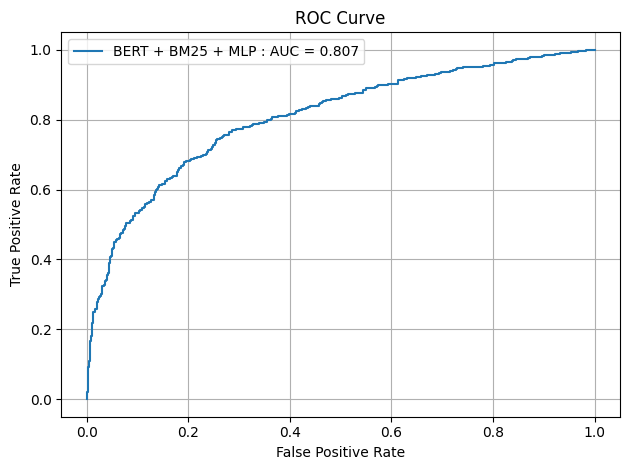

In [ ]:
evaluate_ap_and_auroc(
    y_test_tensor=[y_test_tensor.numpy()],
    test_preds=[test_preds_probs],
    exp_names=['BERT + BM25 + MLP']
)